# NN Shape Analysis - Power Grid

In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D

from scipy import stats

In [6]:
with open("NetworkShapeAnalysis_grid_Tanh1.json", 'r') as nsa:
    data = json.load(nsa)
print(len(data))
with open("NetworkShapeAnalysis_grid_Tanh2.json", 'r') as nsa:
    data.update(json.load(nsa))
    


acc_lim = [0.65, 0.95]
iqr_lim = [0,0.05]

def str_to_list(in_string):
    temp = in_string[1:-1].split(',')
    return [int(s) for s in temp]

score_num = 0
for t,d in data.items():
    if type(d) is int: continue
    d["shape"] = str_to_list(d["shape"])
    d["hidden"] = len(d["shape"]) - 2
    acc = d["accs"]
    scores = (list(acc.values()))
    scores = np.vstack([np.array(s) for s in scores])[score_num]
    d["medians"] = np.median(scores)
    d["iqr"] = np.quantile(scores, 0.75) - np.quantile(scores, 0.25)
    #for i in range(d["hidden"]):
    #    d["shrink"] = d.get("shrink", 1) * (d["shape"][i] / d["shape"][i + 1]) ** (d["hidden"] + 1 - i)
    #d['loc'], d['spread'] = stats.gumbel_r.fit(scores)
    d["u75"] = scores.max() - np.quantile(scores, 0.25)
    d["synapses"] = sum([n * d["shape"][i + 1] for i,n in enumerate(d["shape"][:-1])])
    #print(d)
    #input()
    

882


RuntimeError: dictionary changed size during iteration

In [5]:
df = pd.DataFrame.from_dict(data, orient = "index")
#print(df.head())
print(df["hidden"].value_counts())
if "computer" in df.columns:
    df.drop(["computer"], axis = 1, inplace = True)
    df.dropna(how = "all", inplace = True)
#df.head()

AttributeError: 'int' object has no attribute 'items'

No handles with labels found to put in legend.


(0.65, 0.95)

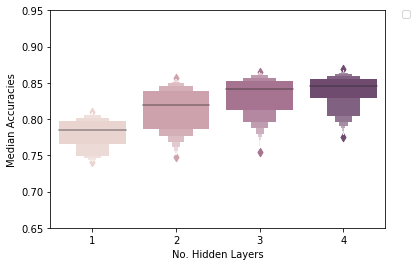

In [12]:
# Plot median accuracy vs num hidden layers
sns.boxenplot(x = "hidden", y = "medians", data = df, palette = sns.cubehelix_palette(4, dark=0.35))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylabel("Median Accuracies")
plt.xlabel("No. Hidden Layers")
plt.ylim(acc_lim)

No handles with labels found to put in legend.


(0, 0.05)

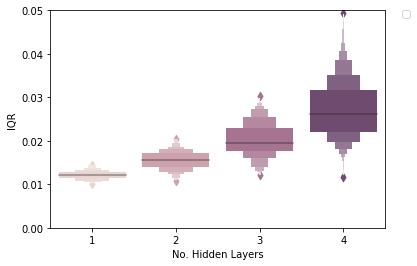

In [13]:
# Plot accuracy IQR vs num hidden layers
sns.boxenplot(x = "hidden", y = "iqr", data = df, palette = sns.cubehelix_palette(4, dark=0.35))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylabel("IQR")
plt.xlabel("No. Hidden Layers")
plt.ylim(iqr_lim)

In [14]:
def get_nodes_synapses(row):
    shape = row["shape"]
    if type(shape) is float: print(row)
    nodes = pd.Series([None] * (6 - len(shape)) + shape[1:-1], dtype = 'float32')
    nodes.index = ["n{}".format(i) for i in range(4)]
    synapses = {"s{}".format(i) : (shape[i - 6] + 1) * shape[i - 5] for i in range(5) if i - 6 >= -len(shape)}
    synapses = pd.Series(synapses, dtype = "int16")
    nodes_synapses = pd.concat([nodes,synapses])
    
    return nodes_synapses

def get_nodes(row):
    shape = row["shape"]
    if type(shape) is float: print(row)
    nodes = pd.Series(shape[1:-1] + [None] * (6 - len(shape)), dtype = 'float32')
    ratios = pd.Series([n/shape[i+2] for i,n in enumerate(shape[1:-2])] + [None] * (6 - len(shape)), dtype = 'float32')
    ratio_bool = (ratios >= 1).astype(int)
    nodes.index = ["n{}".format(i) for i in range(4)]
    ratios.index = ["n{}n{}".format(i,i+1) for i in range(3)]
    ratio_bool.index = [i+"Bool" for i in ratios.index]
    
    return nodes.append(ratios).append(ratio_bool)

'''
def convolve_synapses(df):
    temp = df[["s0", "s1", "s2", "s3", "s4"]]
    cols = list(temp.columns)[::-1]
    for i in range(1,len(cols)):
        temp.loc[:,cols[i]] = temp[cols[i-1]].dropna() + temp[cols[i]]
    temp.columns = ["c{}".format(i) for i in range(5)]
    return temp
'''

nodes_and_synapses = df.apply(get_nodes, axis = 1)
shape_df = df.drop(["accs"], axis = 1).merge(nodes_and_synapses, how = "left",
                                                    left_index  = True, right_index = True)
#shape_df = shape_df.merge(convolve_synapses(shape_df), how = "left",
#                          left_index  = True, right_index = True)
shape_df.head(10)

,shape,hidden,medians,iqr,u75,synapses,n0,n1,n2,n3,n0n1,n1n2,n2n3,n0n1Bool,n1n2Bool,n2n3Bool
"trial(12, 15, 1)19","[12, 15, 1]",1,0.80070,0.012300,0.029300,195,15.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
"trial(12, 15, 1)20","[12, 15, 1]",1,0.79945,0.010625,0.028200,195,15.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
"trial(12, 15, 1)21","[12, 15, 1]",1,0.80510,0.013925,0.038600,195,15.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
"trial(12, 15, 1)22","[12, 15, 1]",1,0.79930,0.012100,0.029800,195,15.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
"trial(12, 15, 1)23","[12, 15, 1]",1,0.80530,0.013400,0.033000,195,15.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
"trial(12, 15, 1)24","[12, 15, 1]",1,0.80120,0.012925,0.034225,195,15.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
"trial(12, 3, 3, 1)0","[12, 3, 3, 1]",2,0.75685,0.013325,0.036000,48,3.0,3.0,NaN,NaN,1.0,NaN,NaN,1.0,0.0,0.0
"trial(12, 3, 3, 1)1","[12, 3, 3, 1]",2,0.76120,0.013900,0.035200,48,3.0,3.0,NaN,NaN,1.0,NaN,NaN,1.0,0.0,0.0
"trial(12, 3, 3, 1)2","[12, 3, 3, 1]",2,0.74705,0.011500,0.029700,48,3.0,3.0,NaN,NaN,1.0,NaN,NaN,1.0,0.0,0.0
"trial(12, 3, 3, 1)3","[12, 3, 3, 1]",2,0.76110,0.012600,0.034800,48,3.0,3.0,NaN,NaN,1.0,NaN,NaN,1.0,0.0,0.0


In [15]:
yvars = ["medians", "iqr", "u75"]
ylabels = ["Median  Accuracy", "Inter-quartile Range", "Upper 3QR"]

xvars = ["synapses", "n0", "n1", "n2", "n3", "n0n1", "n1n2", "n2n3"]
xlabels = ["Total No. Synapses",
          "Synapses in Hidden Layer 0", "Synapses in Hidden Layer 1",
          "synapses in Hidden Layer 2", "synapses in Hidden Layer 3",
          "N0/N1 Ratio", "N1/N2 Ratio", "N2/N3 Ratio"]

def plot_accuracies(x_num, y_num, hue, hl, sub_data = None, hue_start = 0):
    yvar = yvars[y_num]
    ylabel = ylabels[y_num]
    ylim = [acc_lim, iqr_lim][y_num]
    
    xvar = xvars[x_num]
    xlabel = xlabels[x_num]
    swarm = x_num != 0 and x_num < 5
    
    data = shape_df[shape_df["hidden"] == hl]
    if sub_data:
        data = data[data[sub_data[0]] == sub_data[1]]
    unique = len(data[hue].value_counts())
    if swarm:
        #title = hue
        plt0 = sns.swarmplot(x = xvar, y = yvar, hue = hue, data = data,
                             palette = sns.cubehelix_palette(unique, start = hue_start),
                             dodge = True, **{"marker":'o'})
    else:
        #title = None
        plt0 = sns.scatterplot(x = xvar, y = yvar, hue = hue, data = data, legend = "full",
                              palette = sns.cubehelix_palette(unique, start = hue_start))
        
    #if x_num in [0,2]:
    title = None
    plt.legend(title = title, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    #else:
    #    norm = matplotlib.colors.Normalize(data[hue].min(), data[hue].max())
    #    cmap = sns.cubehelix_palette(as_cmap=True)
    #    plt0.get_legend().remove()
    #    mappable = matplotlib.cm.ScalarMappable(norm, cmap)
    #    plt0.figure.colorbar(mappable, label = hue)
        
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.ylim(ylim)

## Plot as a function of nodes in first layer
Hue is the number of nodes in first layer divided by nodes in second layer

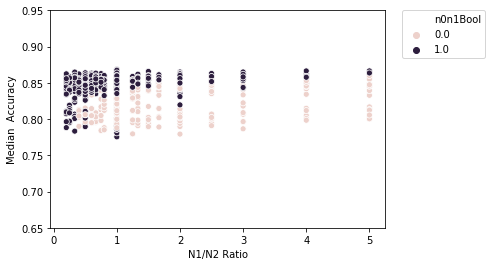

In [17]:
# 4hl, medians, hue = n0n1

x_num = 6
hue = "n0n1Bool"

y_num = 0
hl = 4

plot_accuracies(x_num, y_num, hue, hl)

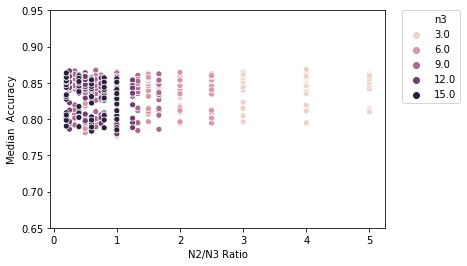

In [24]:
# 4hl, medians, hue = n0n1
# Plots: x = 6, n0; x = 6, n2; x = 7, n3

x_num = 7
hue = "n3"

y_num = 0
hl = 4

plot_accuracies(x_num, y_num, hue, hl)

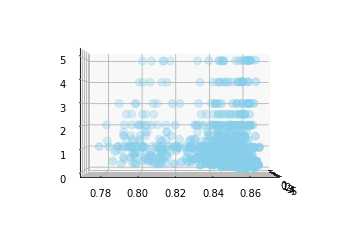

In [161]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
d3f = shape_df[shape_df["hidden"] == hl]
ax.scatter(d3f["n0n1"], d3f[yvars[y_num]], d3f["n1n2"], c='skyblue', s=60)
ax.view_init(0, 0)
plt.show()


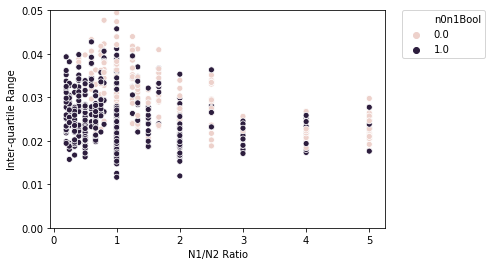

In [20]:
# 4hl, medians, hue = n0n1

x_num = 6
hue = "n0n1Bool"

y_num = 1
hl = 4

plot_accuracies(x_num, y_num, hue, hl)

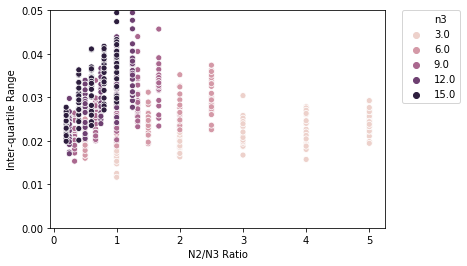

In [25]:
# 4hl, iqr, hue = n0n1
# Plots: x = 6, n0; x = 6, n2; x = 7, n3

x_num = 7
hue = "n3"

y_num = 1
hl = 4

plot_accuracies(x_num, y_num, hue, hl)

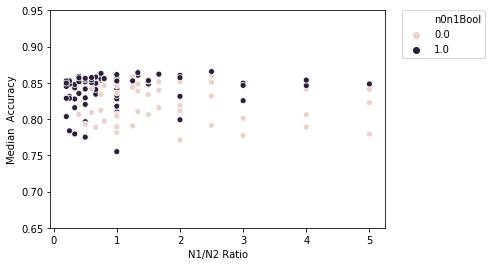

In [26]:
# 3hl, acc, hue = n0n1

x_num = 6
hue = "n0n1Bool"

y_num = 0
hl = 3

plot_accuracies(x_num, y_num, hue, hl)

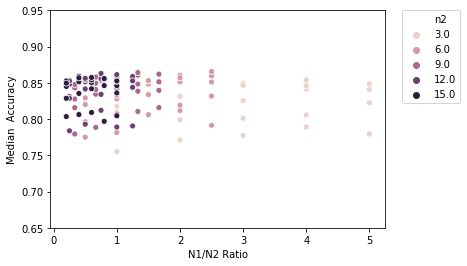

In [33]:
# 3hl, medians, hue = n0n1
# Plots: x = 6, n0; x = 6, n2

x_num = 6
hue = "n2"

y_num = 0
hl = 3

plot_accuracies(x_num, y_num, hue, hl, hue_start = 0)

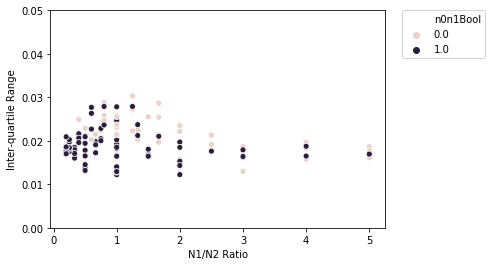

In [29]:
# 3hl, iqr, hue = n0n1

x_num = 6
hue = "n0n1Bool"

y_num = 1
hl = 3

plot_accuracies(x_num, y_num, hue, hl)

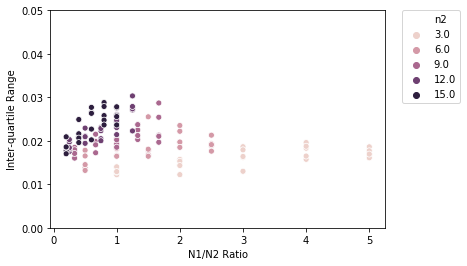

In [32]:
# 3hl, iqr, hue = n0n1
# Plots: x = 6, n0; x = 6, n2

x_num = 6
hue = "n2"

y_num = 1
hl = 3

plot_accuracies(x_num, y_num, hue, hl)

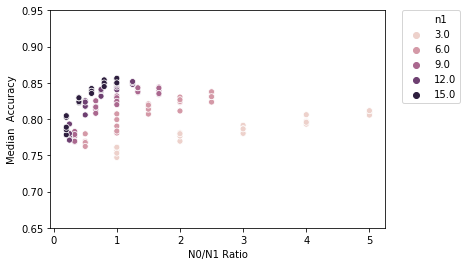

In [34]:
# 2hl, medians, hue = n0n1

x_num = 5
hue = "n1"

y_num = 0
hl = 2

plot_accuracies(x_num, y_num, hue, hl)

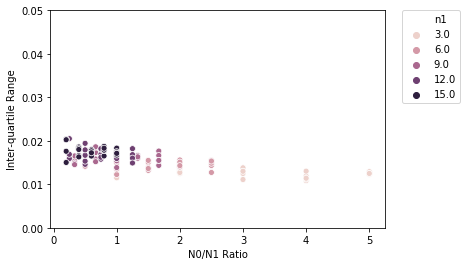

In [35]:
# 2hl, iqr, hue = n0n1

x_num = 5
hue = "n1"

y_num = 1
hl = 2

plot_accuracies(x_num, y_num, hue, hl)

## Plot as a function of nodes in second hidden layer
Hue is ratio of n1 / n2

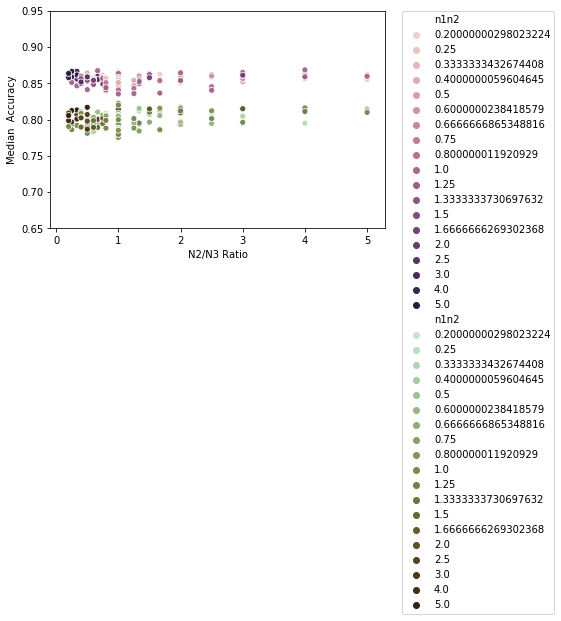

In [224]:
# 4hl, medians, hue = n1n2

x_num = 7
hue = "n1n2"

y_num = 0
hl = 4

plot_accuracies(x_num, y_num, hue, hl, sub_data = ["n0",15])
plot_accuracies(x_num, y_num, hue, hl, sub_data = ["n0",3], hue_start = 1)

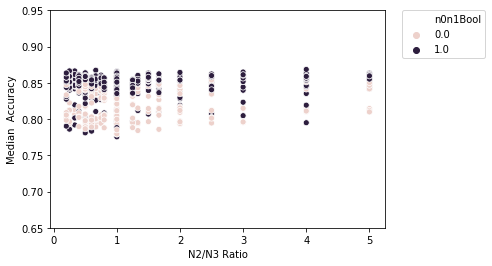

In [230]:
# 4hl, medians, hue = n1n2

x_num = 7
hue = "n0n1Bool"

y_num = 0
hl = 4

plot_accuracies(x_num, y_num, hue, hl)

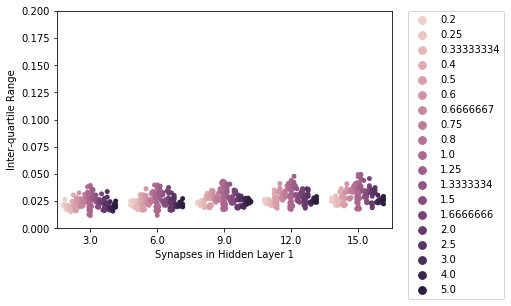

In [61]:
# 4hl, iqr, hue = n1n2
y_num = 1

plot_accuracies(x_num, y_num, hue, hl)

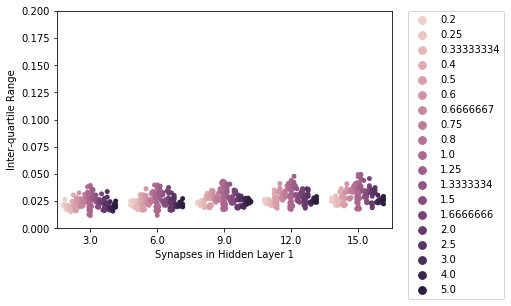

In [61]:
# 4hl, iqr, hue = n1n2
y_num = 1

plot_accuracies(x_num, y_num, hue, hl)

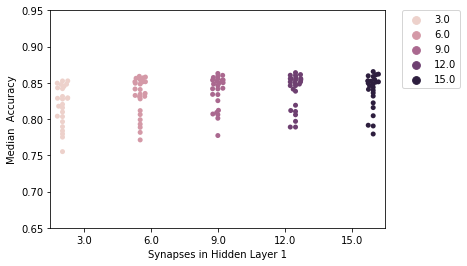

In [63]:
# 3hl, medians, hue = n1n2

hue = xvars[x_num]
y_num = 0
hl = 3

plot_accuracies(x_num, y_num, hue, hl)

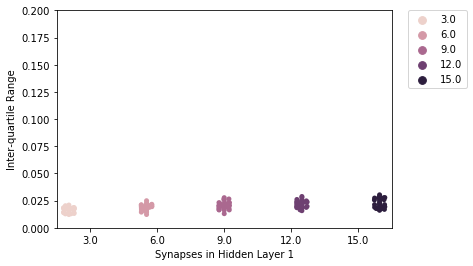

In [64]:
# 3hl, iqr, hue = n1n2
y_num = 1
plot_accuracies(x_num, y_num, hue, hl)

## Plot as a function of nodes in third layer
Hue is number of nodes in last hidden layer

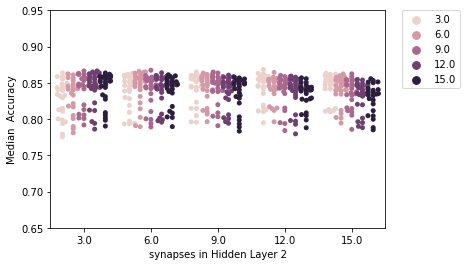

In [18]:
# 4hl, medians, hue = n3

x_num = 3
hue = "n3"

y_num = 0
hl = 4

plot_accuracies(x_num, y_num, hue, hl)

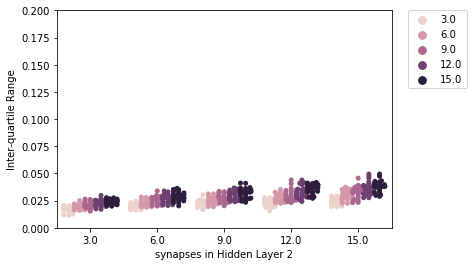

In [19]:
# 4hl, iqr, hue = n3
y_num = 1

plot_accuracies(x_num, y_num, hue, hl)